ECE194N/594N HW2: Shapes

Mikolaj Godzik and Jose Nunez

In this project, we will be visualizing a dataset for our final project, in which we will be classifying cell cycle stages, using cell nuclei and membrane shape as predictors. The dataset examined here comes from the following paper: https://www.nature.com/articles/s41586-022-05563-7, specifically, the supplementary dataset that coantains labeled data of 5,664 cells, which may be accessed here: https://open.quiltdata.com/b/allencell/packages/aics/mitotic_annotation. 
The dataset consists of raw microscopy images of cells with 3 channels: nuclear dye, membrane dye, and a single, endogenous protein tagged with a fluorescent protein, as well as segmented, binary images of the same cells, consisting of 2 channels: nuclear dye binary segmentation and membrane dye binary segmentation. We will be examining the latter set of images, as all pre-processing and segmentation have already been implemented for these images.

# 1. Installing libraries, downloading data, exploring metadata


In [ ]:
pip install opencv-python

In [ ]:
pip install geomstats

In [ ]:
pip install quilt3

In [64]:
import pandas as pd
import numpy as np
import quilt3 as q3
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
import os
from tifffile import imread
import geomstats.geometry
from geomstats.geometry.pre_shape import PreShapeSpace
from geomstats.geometry.discrete_curves import SRVShapeBundle,R2,DiscreteCurves,SRVMetric
from geomstats.geometry.euclidean import Euclidean
from geomstats.geometry.discrete_curves import SRVQuotientMetric
import geomstats.backend as gs
from geomstats.geometry.discrete_curves import R2, DiscreteCurves, SRVMetric
from geomstats.learning.frechet_mean import FrechetMean
from scipy.stats import gaussian_kde
from geomstats.geometry.hypersphere import Hypersphere
from geomstats.learning.frechet_mean import FrechetMean
from sklearn.model_selection import train_test_split
from geomstats.learning.preprocessing import ToTangentSpace
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from scipy import stats
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from geomstats.geometry.hypersphere import Hypersphere

In [10]:
meta = pd.read_csv('metadata.csv')
meta.head()

,CellId,label,crop_raw,crop_seg
0,af726df3-a641-4cec-897c-5a5a3ce9d70f,blob,crop_raw/8cefb076_raw.ome.tif,crop_seg/1119158e_segmentation.ome.tif
1,89c3aabd-1a38-4ec8-ba26-ca86706a948c,blob,crop_raw/0480229d_raw.ome.tif,crop_seg/fc03204c_segmentation.ome.tif
2,591b317b-b6c4-4a7d-a602-494bb919e4e5,blob,crop_raw/5bba3b6a_raw.ome.tif,crop_seg/a79c4e8d_segmentation.ome.tif
3,2f71b11c-cf78-4285-9c19-f6702feeb225,blob,crop_raw/e60cc3bd_raw.ome.tif,crop_seg/dbd8fa8d_segmentation.ome.tif
4,f409a4ec-2141-492d-a506-9d0ed8f0f6c7,blob,crop_raw/8b1cc874_raw.ome.tif,crop_seg/70f426dd_segmentation.ome.tif


As seen above, the metadata column contains path files for the raw and segmented images, as well as labels for each cell. All unique labels are shown below:

In [11]:
print(meta['label'].unique())

['blob' 'dead' 'wrong' 'M0' 'M1M2' 'M3' 'M4M5' 'M6M7_half' 'M6M7_early']


These labels should be sufficient for training our learning model. The label 'blob' refers to intracellular dye aggregates, rather than true cells. 'Wrong' refers to cells that were incorrectly segmented. 'Dead' refers to cells that had died or were in the process of dying during imaging. These outlier cells will not be used for classification of cell cycle stage. The rest of the labels refer to a specific stage of the cell cycle that the cell was in during imaging. Finally, the column 'CellId' refers to a unique label for each cell imaged. 

In [12]:
print(meta['label'].value_counts())

M0            2516
M4M5           927
M3             823
M6M7_half      561
M1M2           441
M6M7_early     338
dead           103
wrong           35
blob            20
Name: label, dtype: int64


The vast majority of cells do not belong to any outlier groups (2.7% total). Overall, the dataset is biased towards M0, or interphase cells (~44% of total dataset). 

# 2. Preprocessing and Data Visualization

In [13]:
def clean_labels(dataframe):
    clean_dataframe = dataframe[dataframe['label'].isin(['M0','M1M2','M3','M4M5','M6M7_half','M6M7_early'])].sort_values(by='label')
    return clean_dataframe

In [14]:
clean_meta = clean_labels(meta)

In [15]:
def grab_path(path):
    im_path = path.split('/')[1]
    return im_path

In [17]:
paths_dict = {}
for label in list(meta['label'].unique()):
    path = meta[meta['label']==str(label)].iloc[0]['crop_seg'].split('/')[1]
    im_data_label = imread(path)
    if im_data_label.shape[1] != 2:
        im_data_label = np.moveaxis(im_data_label,0,1)
    paths_dict[label] = [path,im_data_label[45,:,:,:]]

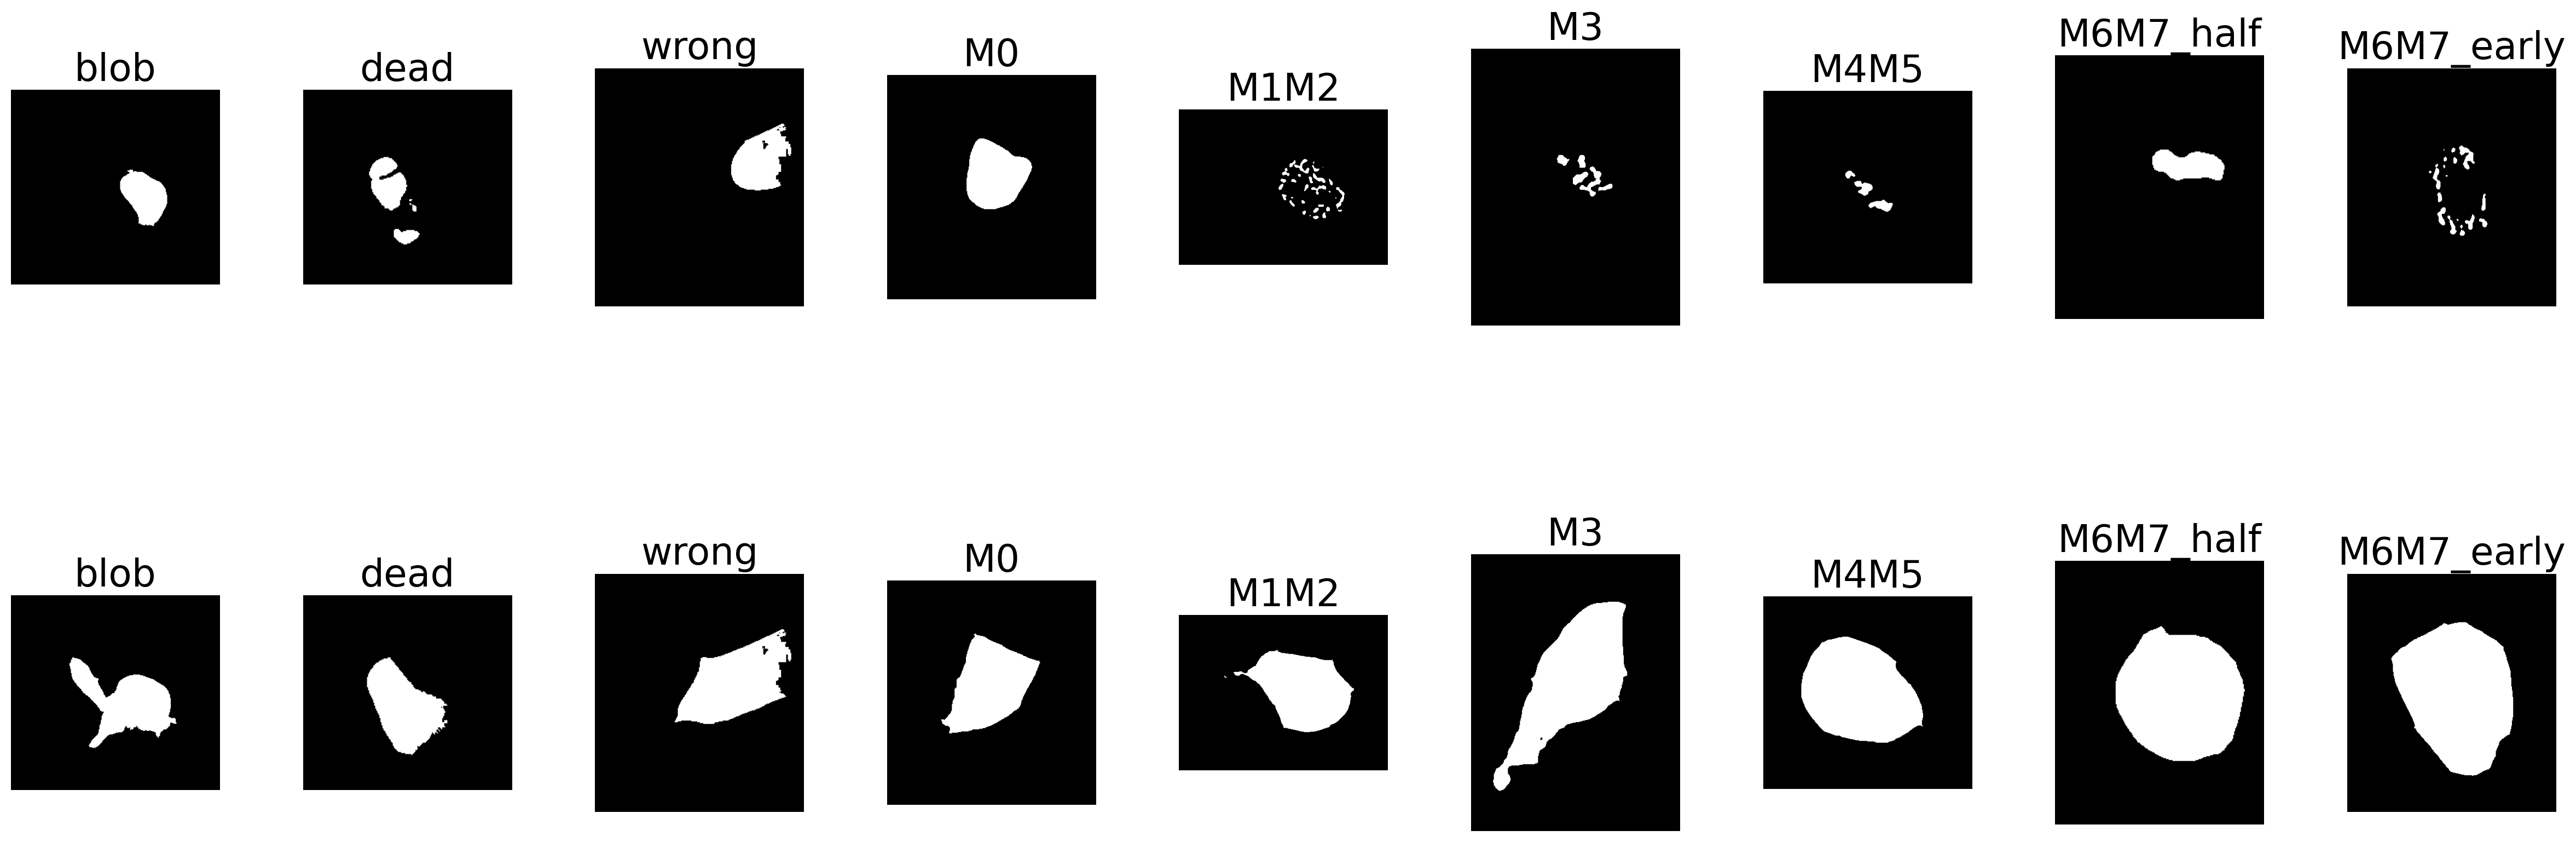

In [18]:
fig, ax = plt.subplots(figsize=(30,30),ncols=len(paths_dict),nrows=2, dpi=200)
fig.subplots_adjust(wspace=0.4)
i = 0
for label in paths_dict:
  ax[0,i].imshow(paths_dict[label][1][0,:,:], cmap = 'gray')
  ax[0,i].axis('off')
  ax[0,i].set_title('{}'.format(label),fontsize=25)
  ax[1,i].imshow(paths_dict[label][1][1,:,:], cmap = 'gray')
  ax[1,i].axis('off')
  ax[1,i].set_title('{}'.format(label),fontsize=25)
  i = i + 1
fig.subplots_adjust(hspace=-0.75)
#fig.subplots_adjust(wspace=-5)
#plt.tight_layout()
plt.savefig('sample_binaries.png',bbox_inches='tight')
plt.show()

Shown above is a sample of cell images, one from each unique label, with the leftmost row representing the nuclear binary channel, and the rightmost row representing the membrane binary channel. We see a potential problem with our dataset: some cells, such as the one shown with label M6M7_half, have round, continuous/smooth nuclei, while others, such as the one shown with label M3, have discrete punctae-like segmented nuclei. 

In [19]:
def shape_dists(dataframe):
    nuc_dict = {}
    mem_dict = {}
    for label in list(dataframe['label'].unique()):    
        sliced = dataframe[dataframe['label']==label]
        nuc_vals = []
        mem_vals = []
        im_paths = sliced['crop_seg'].apply(grab_path)
        for path in im_paths:
            im_data = imread(path)
            if im_data.shape[1] != 2:
                im_data = np.moveaxis(im_data,0,1)
            retvals_nuc,_,_,_ = cv2.connectedComponentsWithStats(im_data[45,0,:,:])
            retvals_mem,_,_,_ = cv2.connectedComponentsWithStats(im_data[45,1,:,:])
            nuc_vals.append(retvals_nuc)
            mem_vals.append(retvals_mem)
        nuc_dict[label] = nuc_vals
        mem_dict[label]= mem_vals
    return nuc_dict,mem_dict

In [20]:
outvar_nuc,outvar_mem = shape_dists(clean_meta)

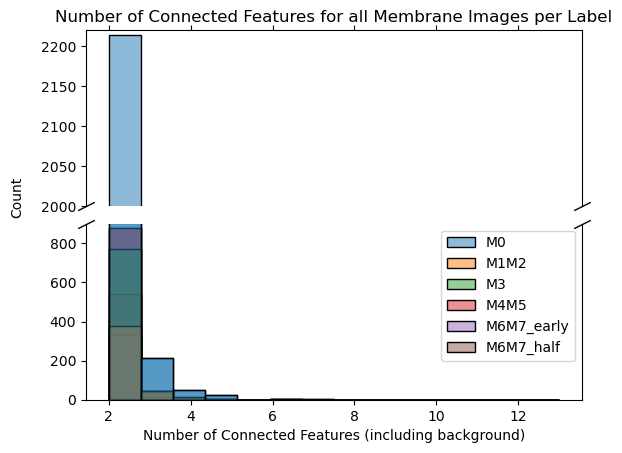

In [21]:
fig,(ax1,ax2) = plt.subplots(2,1,sharex=True)
fig.subplots_adjust(hspace=0.1)
plot = sns.histplot(outvar_mem)
sns.histplot(outvar_mem,ax=ax1,legend=False)
ax1.set_ylim((2000,2220))
ax2.set_ylim((0,900))
sns.histplot(outvar_mem,ax=ax2)
ax1.set(ylabel=None)
ax2.yaxis.set_label_coords(-0.125, 1.15)
ax1.spines.bottom.set_visible(False)
ax2.spines.top.set_visible(False)
ax1.xaxis.tick_top()
ax1.tick_params(labeltop=False)
ax2.xaxis.tick_bottom()
d = .5
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,linestyle="none", color='k', mec='k', mew=1, clip_on=False)
ax1.plot([0, 1], [0, 0], transform=ax1.transAxes, **kwargs)
ax2.plot([0, 1], [1, 1], transform=ax2.transAxes, **kwargs)
ax1.set_title('Number of Connected Features for all Membrane Images per Label')
ax2.set_xlabel('Number of Connected Features (including background)')
plt.savefig('mem_hist.png',bbox_inches='tight')
plt.show()

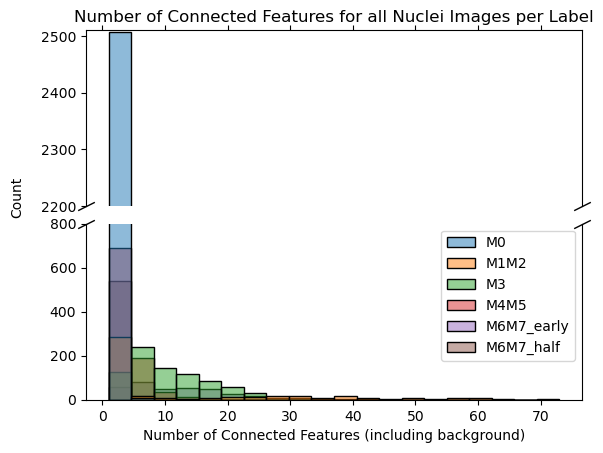

In [22]:
fig,(ax1,ax2) = plt.subplots(2,1,sharex=True)
fig.subplots_adjust(hspace=0.1)
sns.histplot(outvar_nuc,ax=ax1,legend=False,bins=20)
ax1.set_ylim((2200,2510))
ax2.set_ylim((0,800))
sns.histplot(outvar_nuc,ax=ax2,bins=20)
ax1.spines.bottom.set_visible(False)
ax1.set(ylabel=None)
ax2.yaxis.set_label_coords(-0.125, 1.15)
ax2.spines.top.set_visible(False)
ax1.xaxis.tick_top()
ax1.tick_params(labeltop=False)
ax2.xaxis.tick_bottom()
d = .5
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,linestyle="none", color='k', mec='k', mew=1, clip_on=False)
ax1.plot([0, 1], [0, 0], transform=ax1.transAxes, **kwargs)
ax2.plot([0, 1], [1, 1], transform=ax2.transAxes, **kwargs)
ax1.set_title('Number of Connected Features for all Nuclei Images per Label')
ax2.set_xlabel('Number of Connected Features (including background)')
plt.savefig('nuc_hist',bbox_inches='tight')
plt.show()

In [27]:
for key in outvar_nuc:
    mean_key = np.mean(outvar_nuc[key])
    print('{}:{}'.format(key,mean_key))

M0:2.048489666136725
M1M2:12.7437641723356
M3:10.951397326852977
M4M5:3.800431499460626
M6M7_early:11.505917159763314
M6M7_half:2.2941176470588234


As seen above, the mean number of components in nuclei images may be as large as 12 comnponents (such as in label M1M2). To simplify our analysis, we will examine membrane shapes only, and use the function below to identify and select certain conncected components in our images. We will take the second largest component by area (since the largest is background) to represent the cell membrane.

In [24]:
def clean_features(dataframe):
    clean_ims = []
    im_paths = dataframe['crop_seg'].apply(grab_path)
    for path in im_paths:
        im_data = imread(path)
        if im_data.shape[1] != 2:
            im_data = np.moveaxis(im_data,0,1)
        totalLabels, label_ids, values, centroid = cv2.connectedComponentsWithStats(im_data[45,1,:,:])
        output = np.zeros(im_data.shape, dtype="uint8")
        areas = []
        for i in range(0, totalLabels):
            area = values[i, cv2.CC_STAT_AREA]
            areas.append(area)
        mem_likely_idx = areas.index(max(areas[1:len(areas)]))
        mem_mask = (label_ids==mem_likely_idx)*255
        clean_ims.append(mem_mask)
    dataframe['clean_images'] = clean_ims
    return dataframe

In [25]:
clean_meta = clean_features(clean_meta)

# 3. Parametrization

In [28]:
'''
Don't need to run if data_subset_2 is saved locally
'''

counter = 0
#number of parametrization points per cell
para_size = 100
#dim = number of cells, nuclear vs membrane, points on curve, x vs y
cells = np.zeros((len(clean_meta),para_size,2))

for i in clean_meta.index:
  #read in images from local and extract 32nd Z slices
    img = np.float32(clean_meta['clean_images'][i])
    im_data = img.astype(np.uint8)
    
    if im_data.mean() < 8:
        cntr_mem = np.zeros((para_size,2))
    else:
        contours_mem = cv2.findContours(im_data, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        contours_mem = contours_mem[0] if len(contours_mem) == 2 else contours_mem[1]
    if len(contours_mem) == 2 and len(contours_mem[1]) > len(contours_mem[0]):
        cntr_mem = contours_mem[1]
    else:
        cntr_mem = contours_mem[0]
    cntr_mem = np.asarray(cntr_mem)
    cntr_mem = np.reshape(cntr_mem,(cntr_mem.shape[0],2))
    first = cntr_mem[0]; last = cntr_mem[-1]
    choice_mem = np.random.choice(range(cntr_mem.shape[0]), size=(para_size-2,1), replace=False)
    ind_mem = np.zeros(cntr_mem.shape[0], dtype=bool)
    ind_mem[choice_mem] = True
    cntr_mem = cntr_mem[ind_mem]
    cntr_mem = np.concatenate((first.reshape((1,2)), cntr_mem, last.reshape((1,2))))
    
    new = np.stack(cntr_mem,axis=0)
    cells[counter,:,:] = new
    counter += 1

In [29]:
#cells = np.load('data_subset_2.npy')
para_size = 100

In [30]:
# makes sure there are only unique sampling points
for j,curve in enumerate(cells):
    dist = curve[1:] - curve[:-1]
    dist_norm = np.sqrt(np.sum(np.square(dist), axis=1))
    if np.any( dist_norm < 1e-10 ):
        for i in range(len(curve)-1):
            if np.sqrt(np.sum(np.square(curve[i+1] - curve[i]), axis=0)) < 1e-10:
                curve[i+1] = (curve[i] + curve[i-1]) / 2
    cells[j] = curve

In [31]:
labels = clean_meta['label']
cell_states = clean_meta['label'].unique()

array(['M0', 'M1M2', 'M3', 'M4M5', 'M6M7_early', 'M6M7_half'],
      dtype=object)

In [32]:
def interpolate(curve, nb_points):
    """Interpolate a discrete curve with nb_points from a discrete curve.

    Returns
    -------
    interpolation : discrete curve with nb_points points
    """
    old_length = curve.shape[0]
    interpolation = gs.zeros((nb_points, 2))
    incr = old_length / nb_points
    pos = 0
    for i in range(nb_points):
        index = int(gs.floor(pos))
        interpolation[i] = curve[index] + (pos - index) * (
            curve[(index + 1) % old_length] - curve[index]
        )
        pos += incr
    return interpolation


k_sampling_points = 100

In [33]:
clean_meta = clean_meta.reset_index()

In [34]:
# creates dictionary labeled by cell state
ds = {}
for state in cell_states:
    ds[state] = np.zeros((0,para_size,2))
for j in clean_meta.index:
    ds[clean_meta['label'][j]]= np.vstack((ds[clean_meta['label'][j]], cells[j].reshape(1,para_size,2)))#[cell_arr for cell_arr in cells if ]

In [35]:
M_AMBIENT = 2

PRESHAPE_SPACE = PreShapeSpace(m_ambient=M_AMBIENT, k_landmarks=100)
PRESHAPE_METRIC = PRESHAPE_SPACE.embedding_space.metric

r2 = Euclidean(dim=2); curves_r2 = DiscreteCurves(ambient_manifold=r2, k_sampling_points=100)
preshape = PreShapeSpace(m_ambient=2, k_landmarks=100)
shape_bundle = SRVShapeBundle(ambient_manifold=r2, k_sampling_points=100)

srv_quotient_metric = SRVQuotientMetric(
    ambient_manifold=r2, 
    k_sampling_points=100)

INFO: Using numpy backend


In [36]:
# how to apply any function to our dictionary
def apply_func_to_ds(input_ds, func):
    output_ds = {}
    for state in cell_states:
        output_ds[state] = np.zeros((ds[state].shape[0],para_size,2))
        for i,arr in enumerate(input_ds[state]):
            output_ds[state][i] = func(arr)
    return output_ds

In [37]:
def preprocess(curve, tol=1e-10):
    """Preprocess curve to ensure that there are no consecutive duplicate points.

    Returns
    -------
    curve : discrete curve
    """
    dist = curve[1:] - curve[:-1]
    dist_norm = np.sqrt(np.sum(np.square(dist), axis=1))

    if np.any( dist_norm < tol ):
        for i in range(len(curve)-1):
            if np.sqrt(np.sum(np.square(curve[i+1] - curve[i]), axis=0)) < tol:
                curve[i+1] = (curve[i] + curve[i+2]) / 2

    return curve

In [38]:
def exhaustive_align(curve, base_curve):
    """Align curve to base_curve to minimize the L² distance.

    Returns
    -------
    aligned_curve : discrete curve
    """
    nb_sampling = len(curve)
    distances = gs.zeros(nb_sampling)
    base_curve = gs.array(base_curve)
    for shift in range(nb_sampling):
        reparametrized = [curve[(i + shift) % nb_sampling] for i in range(nb_sampling)]
        aligned = PRESHAPE_SPACE.align(point=gs.array(reparametrized), base_point=base_curve)
        distances[shift] = PRESHAPE_METRIC.norm(
            gs.array(aligned) - gs.array(base_curve)
        )
    shift_min = gs.argmin(distances)
    reparametrized_min = [
        curve[(i + shift_min) % nb_sampling] for i in range(nb_sampling)
    ]
    aligned_curve = PRESHAPE_SPACE.align(
        point=gs.array(reparametrized_min), base_point=base_curve
    )
    return aligned_curve

In [39]:
ds_proc = apply_func_to_ds(ds, func=lambda x: preprocess(x))

In [40]:
ds_proj = apply_func_to_ds(ds_proc, func=PRESHAPE_SPACE.projection)

BASE_CURVE = ds_proj['M0'][0]
print("Shape of BASE_CURVE:", BASE_CURVE.shape)

ds_align = apply_func_to_ds(ds_proj, func=lambda x: exhaustive_align(x, BASE_CURVE))

Shape of BASE_CURVE: (100, 2)


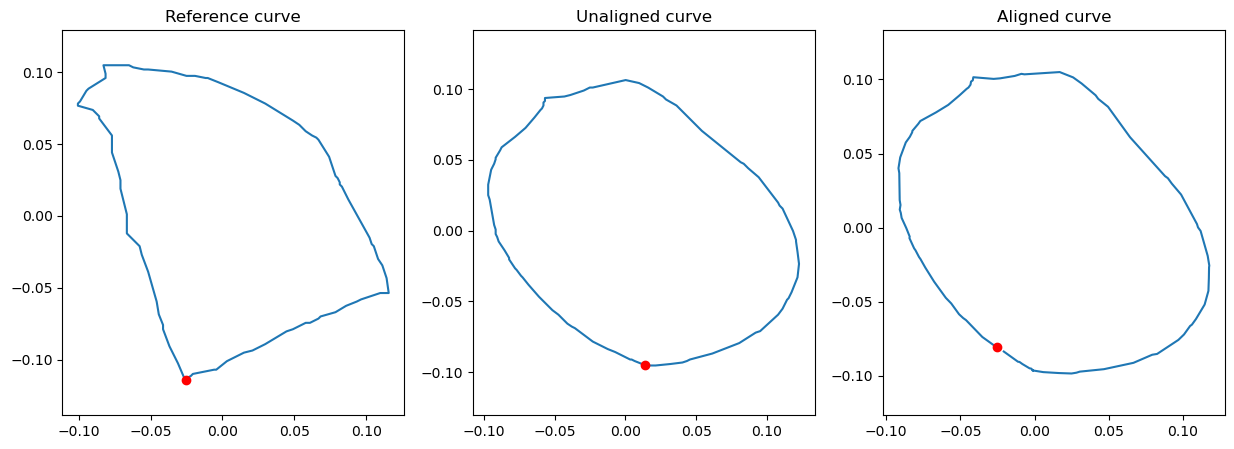

In [41]:
i_rand = gs.random.randint(1000)
unaligned_cell = ds_proj['M0'][i_rand]
aligned_cell = ds_align['M0'][i_rand]

fig = plt.figure(figsize=(15, 5))

fig.add_subplot(131)
plt.plot(BASE_CURVE[:, 0], BASE_CURVE[:, 1])
plt.plot(BASE_CURVE[0, 0], BASE_CURVE[0, 1], "ro")
plt.axis("equal")
plt.title("Reference curve")

fig.add_subplot(132)
plt.plot(unaligned_cell[:, 0], unaligned_cell[:, 1])
plt.plot(unaligned_cell[0, 0], unaligned_cell[0, 1], "ro")
plt.axis("equal")
plt.title("Unaligned curve")

fig.add_subplot(133)
plt.plot(aligned_cell[:, 0], aligned_cell[:, 1])
plt.plot(aligned_cell[0, 0], aligned_cell[0, 1], "ro")
plt.axis("equal")
plt.title("Aligned curve")

plt.savefig("alignment.svg")

The cell above shows the reference curve for barycentering in the leftmost plot, along with the first cell in the dataset in the second plot (shown unaligned). The right plot shows the effect of aligning the first cell to the reference cell shape.

In [42]:
i_start_rand = gs.random.randint(len(ds_proj["M0"]))
i_end_rand = gs.random.randint(len(ds_proj["M4M5"]))

cell_start = ds_align["M0"][i_start_rand]
cell_end = ds_align["M4M5"][i_end_rand]

print(i_start_rand, i_end_rand)

CURVES_SPACE = DiscreteCurves(R2)
SRV_METRIC = CURVES_SPACE.srv_metric

geodesic = SRV_METRIC.geodesic(initial_point=cell_start, end_point=cell_end)

n_times = 30
times = gs.linspace(0.0, 1.0, n_times)
geod_points = geodesic(times)

83 250


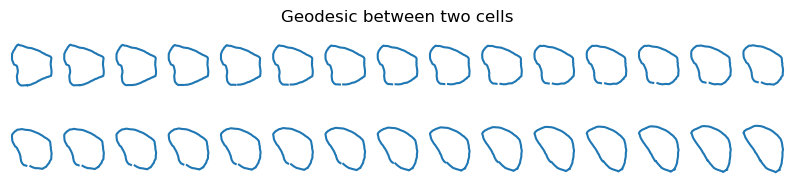

In [43]:
fig = plt.figure(figsize=(10, 2))
plt.title("Geodesic between two cells")
plt.axis("off")

for i, curve in enumerate(geod_points):
    fig.add_subplot(2, n_times // 2, i + 1)
    plt.plot(curve[:, 0], curve[:, 1])
    plt.axis("equal")
    plt.axis("off")
plt.savefig("geodesic_light_blue.svg")

Shown above is the geodesic for two randomly chosen cells in the SRV Quotient Space. 

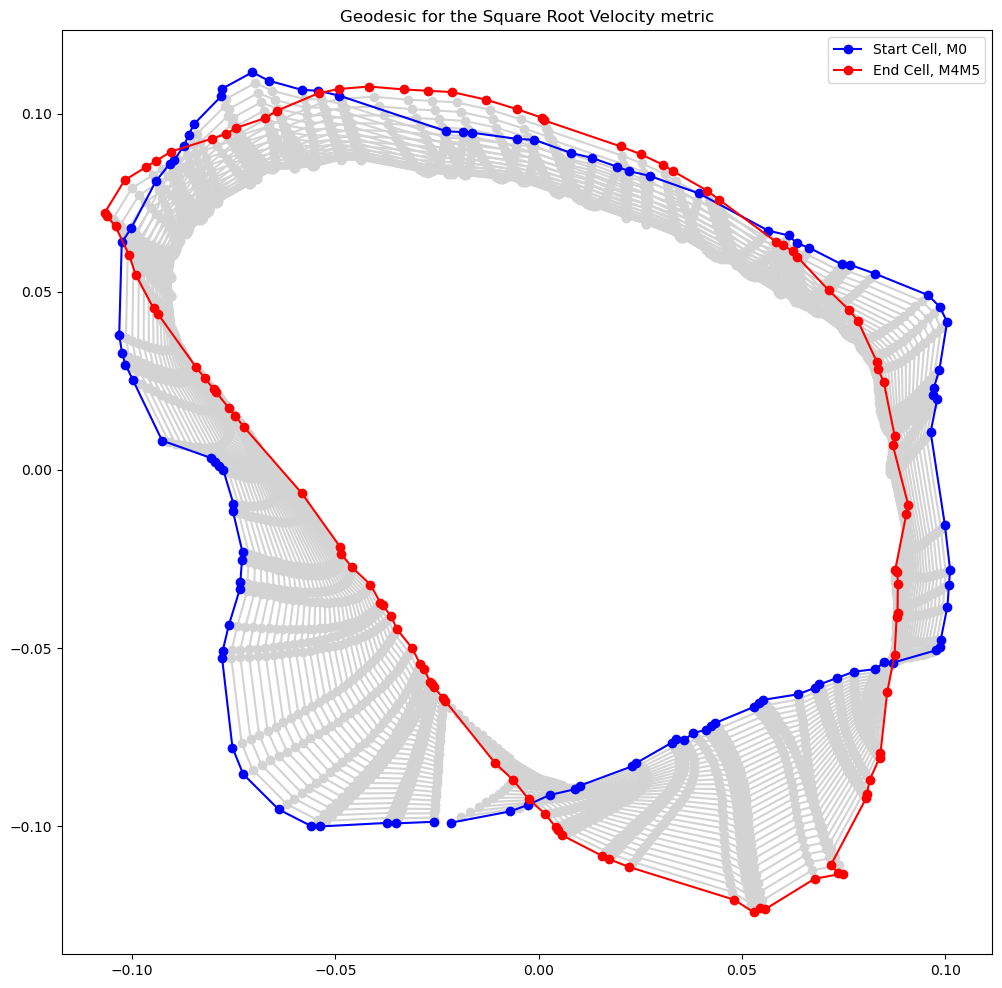

<Figure size 640x480 with 0 Axes>

In [74]:
plt.figure(figsize=(12, 12))
for i in range(1, n_times - 1):
    plt.plot(geod_points[i, :, 0], geod_points[i, :, 1], "o-", color="lightgrey")
plt.plot(geod_points[0, :, 0], geod_points[0, :, 1], "o-b", label="Start Cell, M0")
plt.plot(geod_points[-1, :, 0], geod_points[-1, :, 1], "o-r", label="End Cell, M4M5")

plt.title("Geodesic for the Square Root Velocity metric")
plt.legend()
plt.show()
plt.savefig("geodesic_blue_red.png");

Shown above is the geodesic for two randomly chosen cells in the SRV Quotient Space, just as in the previous plot, but with the indivdual geodesic points illustrated.

In [45]:
cell_shapes_list = []
for state in cell_states:
    cell_shapes_list.extend(ds_align[state])

cell_shapes = gs.array(cell_shapes_list)
print(cell_shapes.shape)

(5606, 100, 2)


In [75]:
mean = FrechetMean(metric=SRV_METRIC, method="default")
mean.fit(cell_shapes[:500])

mean_estimate = mean.estimate_

In [76]:
print(gs.sum(gs.isnan(mean_estimate)))
mean_estimate_clean = mean_estimate[~gs.isnan(gs.sum(mean_estimate, axis=1)), :]
print(mean_estimate_clean.shape)
mean_estimate_clean = interpolate(mean_estimate_clean, k_sampling_points)
print(gs.sum(gs.isnan(mean_estimate_clean)))
print(mean_estimate_clean.shape)

0
(100, 2)
0
(100, 2)


(5606, 100, 2)


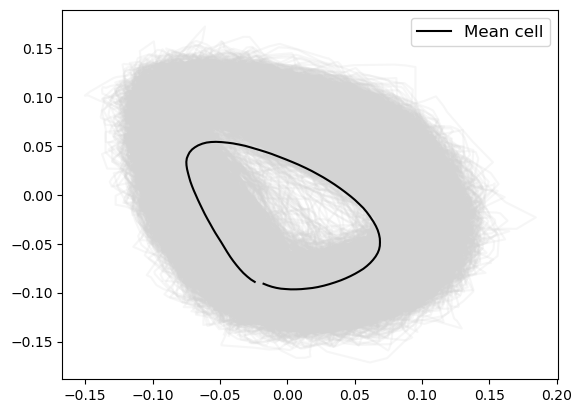

In [48]:
print(cell_shapes.shape)
for cell in cell_shapes:
    plt.plot(cell[:, 0], cell[:, 1], "lightgrey", alpha=0.2)

plt.plot(
    mean_estimate_clean[:, 0], mean_estimate_clean[:, 1], "black", label="Mean cell"
)
plt.legend(fontsize=12)
plt.show()

The above cell shows the global mean cell of all cells in the dataset superimposed on all cells in the dataset. The mean cell is not yet centered.

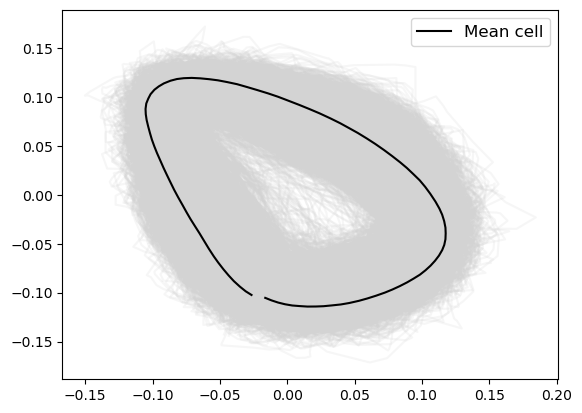

In [49]:
mean_estimate_aligned = 1.55 * (
    mean_estimate_clean - gs.mean(mean_estimate_clean, axis=0)
)

for cell in cell_shapes:
    plt.plot(cell[:, 0], cell[:, 1], "lightgrey", alpha=0.2)

plt.plot(
    mean_estimate_aligned[:, 0], mean_estimate_aligned[:, 1], "black", label="Mean cell"
)
plt.legend(fontsize=12)

plt.show()

The above cell shows the global mean cell of all cells in the dataset superimposed on all cells in the dataset, and centered.

In [50]:
mean_estimate_aligned_bis = gs.vstack(
    [mean_estimate_aligned[4:], mean_estimate_aligned[-1]]
)

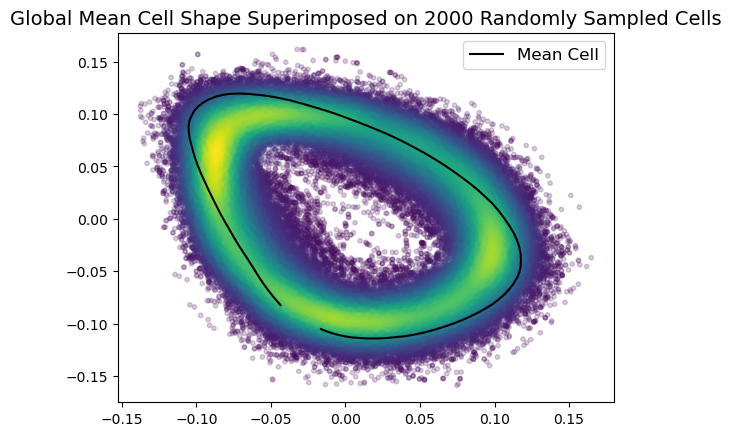

In [51]:
cells_to_plot = cell_shapes[gs.random.randint(len(cell_shapes), size=2000)]
points_to_plot = cells_to_plot.reshape(-1, 2)

z = gaussian_kde(points_to_plot.T)(points_to_plot.T)
z_norm = z / z.max()

plt.scatter(points_to_plot[:, 0], points_to_plot[:, 1], alpha=0.2, c=z_norm, s=10)
plt.plot(
    mean_estimate_aligned_bis[:, 0],
    mean_estimate_aligned_bis[:, 1],
    "black",
    label="Mean Cell",
)
plt.legend(fontsize=12)
plt.title("Global Mean Cell Shape Superimposed on 2000 Randomly Sampled Cells", fontsize=14)

plt.savefig("global_mean_shape.png")

Shown above is the global mean cell superimposed on 2000 randomly sampled cells in the dataset. The cell shapes seem to be relatively uniform in their distribution, roughly tracing out a similar shape to the global mean cell, with few prominment outliers.

In [52]:
dists_to_global_mean = apply_func_to_ds(
    ds_align, func=lambda x: SRV_METRIC.dist(x, mean_estimate_aligned)
)

dists_to_global_mean_list = []
for state in cell_states:
    dists_to_global_mean_list.extend(dists_to_global_mean[state])

In [53]:
gs.where(gs.isnan(dists_to_global_mean_list))

(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))

In [73]:
min_dists = np.min(dists_to_global_mean_list)
max_dists = np.max(dists_to_global_mean_list)

In [55]:
xx = gs.linspace(gs.floor(min_dists), gs.ceil(max_dists), 100)

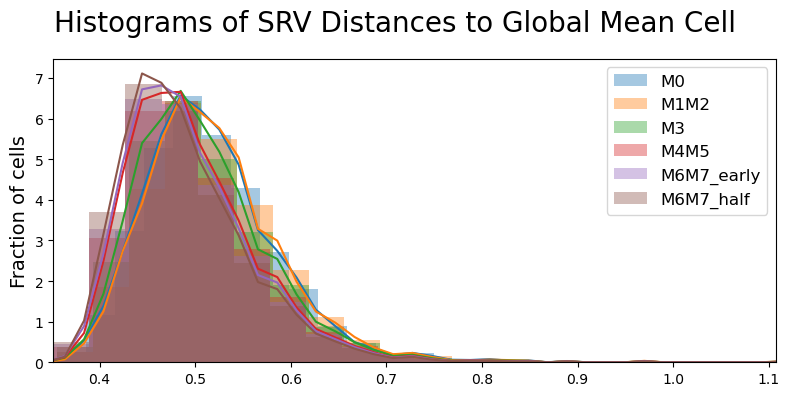

In [56]:
fig, axs = plt.subplots(1, sharex=True, sharey=True, tight_layout=True, figsize=(8, 4))

distances=[]
for i, state in enumerate(cell_states):
    distances.extend(dists_to_global_mean[state][~gs.isnan(dists_to_global_mean[state])])
    color = f"C{i}"
    axs.hist(distances, bins=20, alpha=0.4, density=True, color=color, label=state)
    kde = stats.gaussian_kde(distances)
    axs.plot(xx, kde(xx), color=color)
    axs.set_xlim((min_dists, max_dists))
    axs.legend(fontsize=12)

    #axs.set_title(f"{state} cells", fontsize=14)
    axs.set_ylabel("Fraction of cells", fontsize=14)


fig.suptitle("Histograms of SRV Distances to Global Mean Cell", fontsize=20)
plt.savefig("dist_to_global_mean_per_state_all.png")

Here, we see the distribution of SRV distances to the global mean cell per label. Interestingly, there seems to be a bimodal distribution in labels M0, M1M2, and M3, despite all of these cells being the same cell type.

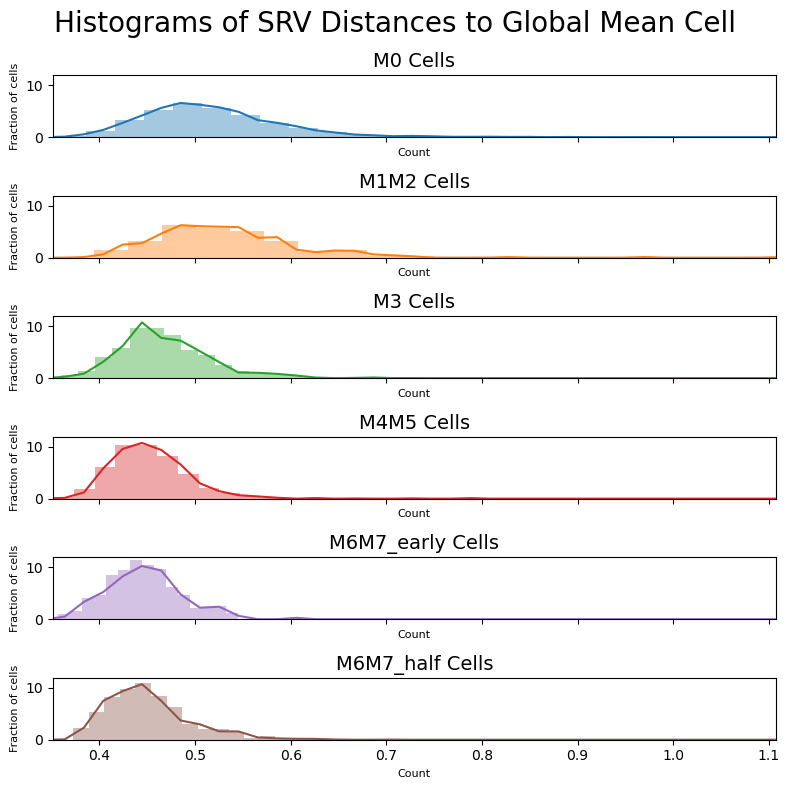

In [57]:
fig, axs = plt.subplots(6, sharex=True, sharey=True, tight_layout=True, figsize=(8, 8))
for i, state in enumerate(cell_states):
    axs[0].set_xlim((min_dists, max_dists))
    distances = dists_to_global_mean[state][
        ~gs.isnan(dists_to_global_mean[state])
    ]
    color = f"C{i}"
    axs[i].hist(
        distances, bins=20, alpha=0.4, density=True, color=color, label=state
    )
    kde = stats.gaussian_kde(distances)
    axs[i].plot(xx, kde(xx), color=color)

    axs[i].set_title(f"{state} Cells", fontsize=14)
    axs[i].set_ylabel("Fraction of cells", fontsize=8)
    axs[i].set_xlabel("Count", fontsize=8)
    #axs[i].legend(fontsize=12)

fig.suptitle("Histograms of SRV Distances to Global Mean Cell", fontsize=20)
plt.savefig("dist_to_global_mean_per_state_individual.png")

Shown above is the distriubtion of SRV distances to the global mean cell, with each individual plot representing a particular label. The bimodal distributions in the top 3 cell labels are shown more clearly, as are the unimodal distributions of the bottom 3 cell labels.

In [58]:
mean_state_cells = {}
for state in cell_states:
    state_cells = []
    state_cells.extend(ds_align[state])
    mean_estimator = FrechetMean(metric=SRV_METRIC)
    mean_estimator.fit(state_cells[:225])
    mean_state_cells[state] = mean_estimator.estimate_


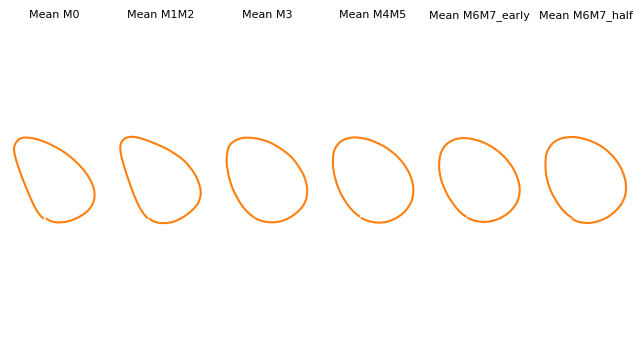

In [59]:
fig = plt.figure(figsize=(8, 4))
i = 1
for state in cell_states:
    mean_cell = mean_state_cells[state]
    fig.add_subplot(1, len(cell_states), i)
    i = i + 1
    plt.plot(mean_cell[:, 0], mean_cell[:, 1], color=f"C1")
    plt.axis("equal")
    plt.axis("off")
    plt.title(f"Mean {state}", fontsize=8)
plt.savefig("mean_cell_state.png")

As seen above, there seeems to be little difference in mean membrane shape between cells of different labels. This could be an issue when classifying cell states based exclusively on membrane shape.

In [60]:
dists_to_own_mean = {}
nan_ids = {}
for state in cell_states:
    dists_to_own_mean[state] = {}
    nan_ids[state] = {}
    dists = []
    ids = []
    for i_curve, curve in enumerate(ds_align[state]):
        one_dist = SRV_METRIC.dist(curve, mean_state_cells[state])
        if ~gs.isnan(one_dist):
            dists.append(one_dist)
        else:
            ids.append(i_curve)
    dists_to_own_mean[state] = dists
    nan_ids[state] = ids

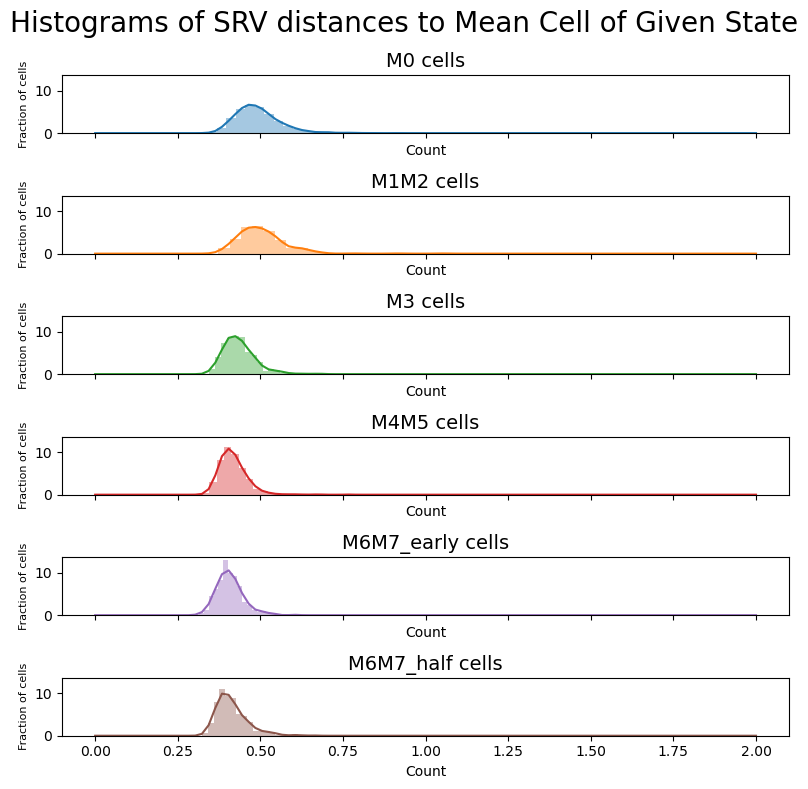

In [61]:
fig, axs = plt.subplots(6, sharex=True, sharey=True, tight_layout=True, figsize=(8, 8))

for i, state in enumerate(cell_states):
    distances = dists_to_own_mean[state]
    color = f"C{i}"
    axs[i].hist(
        distances, bins=20, alpha=0.4, density=True, color=color, label=state
    )
    kde = stats.gaussian_kde(distances)
    axs[i].plot(xx, kde(xx), color=color)

    axs[i].set_title(f"{state} cells", fontsize=14)
    axs[i].set_xlabel('Count')
    axs[i].set_ylabel("Fraction of cells", fontsize=8)
    #axs[i].legend(fontsize=12)

fig.suptitle("Histograms of SRV distances to Mean Cell of Given State", fontsize=20)
plt.savefig("dist_to_state_mean.png")

Here, we see the distribution of SRV distances to the mean of a given cell label. The distributions are more clearly unimodal in all labels, indicating a higher degree of shape homogeneity among cells in a given state. 

# 5. Implementing Logistic Regression Cell-State Classifier
To classify cell states based on membrane shapes, we implement a logistic regression-based classifier. Using an 80/20 training-test split of our cell data, we analyze our data at the tangent space, then run a logistic regression algorithm to classify cell states. 

In [65]:
x_train, x_test, y_train, y_test = train_test_split(cells[:,:,:],labels)

In [ ]:
lr_pipeline = Pipeline(
    steps=[
        ("trick_tangent_space", ToTangentSpace(geometry=shape_bundle)),
        ("classifier", LogisticRegression(C=2)),
    ]
)
lr_pipeline.fit(x_train,y_train)
print(f"We get an accuracy of {lr_pipeline.score(x_test, y_test):.2f}.")